In [1]:
import xarray as xr
import numpy as np
import intake

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
gl_cat=intake.open_catalog("https://raw.githubusercontent.com/CliDyn/GlobalLab_hackathon_2025/refs/heads/main/catalog/main.yaml")

organisation="AWI" # ICCP, 
expid = 'UHR_N39'  # "UHR_N43"

realm='ocean'  # 'ocean' , 'atmos'
gridspec = 'native' # 'native', 'remap'

cat_data=gl_cat[organisation][expid][realm][gridspec]
print(list(cat_data))

['ocean_daily_surface', 'ocean_daily_depth', 'ocean_monthly']


In [10]:
data = cat_data['ocean_monthly'].to_dask()

In [11]:
data

<xarray.Dataset>
Dimensions:       (time: 768, nod2: 12952215, nz: 48, nz1: 47)
Coordinates:
  * nz            (nz) float64 0.0 5.0 10.0 20.0 ... 5.65e+03 6e+03 6.25e+03
  * nz1           (nz1) float64 2.5 7.5 15.0 ... 5.525e+03 5.825e+03 6.125e+03
  * time          (time) datetime64[ns] 1951-01-31T23:57:00 ... 2014-12-31T23...
Dimensions without coordinates: nod2
Data variables: (12/16)
    MLD1          (time, nod2) float32 dask.array<chunksize=(1, 65536), meta=np.ndarray>
    MLD2          (time, nod2) float32 dask.array<chunksize=(1, 65536), meta=np.ndarray>
    MLD3          (time, nod2) float32 dask.array<chunksize=(1, 65536), meta=np.ndarray>
    N2            (time, nz, nod2) float32 dask.array<chunksize=(1, 3, 996325), meta=np.ndarray>
    alb           (time, nod2) float32 dask.array<chunksize=(1, 65536), meta=np.ndarray>
    ist           (time, nod2) float32 dask.array<chunksize=(1, 65536), meta=np.ndarray>
    ...            ...
    qsi           (time, nod2) float32 dask.array<chunksize=(1, 65536), meta=np.ndarray>
    salt          (time, nz1, nod2) float32 dask.array<chunksize=(1, 3, 996325), meta=np.ndarray>
    temp          (time, nz1, nod2) float32 dask.array<chunksize=(1, 3, 996325), meta=np.ndarray>
    unod          (time, nz1, nod2) float32 dask.array<chunksize=(1, 3, 996325), meta=np.ndarray>
    vnod          (time, nz1, nod2) float32 dask.array<chunksize=(1, 3, 996325), meta=np.ndarray>
    w             (time, nz, nod2) float32 dask.array<chunksize=(1, 3, 996325), meta=np.ndarray>
Attributes: (12/20)
    CDI:                           Climate Data Interface version 2.0.5 (http...
    Conventions:                   CF-1.6
    FESOM_model:                   FESOM2
    FESOM_website:                 fesom.de
    FESOM_git_SHA:                 e23bc823
    FESOM_MeshPath:                /work/ab0995/a270067/fesom2/next/mesh/
    ...                            ...
    FESOM_evp_rheol_steps:         120
    FESOM_opt_visc:                7
    FESOM_use_wsplit:              -1
    FESOM_autorotate_back_to_geo:  0
    history:                       Wed Aug 14 11:54:45 2024: cdo cat w.fesom....
    CDO:                           Climate Data Operators version 2.0.5 (http...

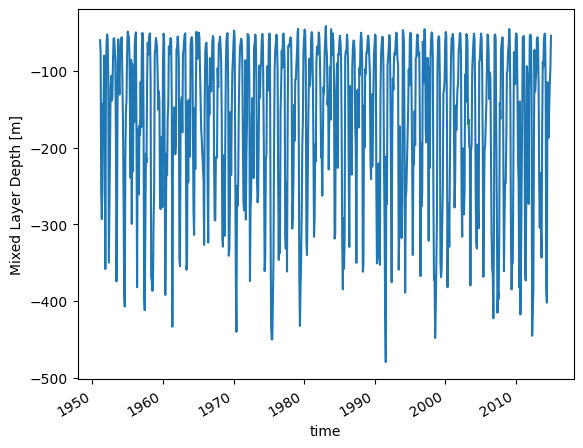

In [8]:
data['MLD1'][:,100].plot()

In [3]:
import intake
import xarray as xr
import pandas as pd
from tqdm.auto import tqdm
import textwrap

catalog_url = "https://raw.githubusercontent.com/CliDyn/GlobalLab_hackathon_2025/refs/heads/main/catalog/main.yaml"

model = "ifs-fesom2-sr"
version = "v20240304"

expids   = [
    'UHR_N39', 
    'UHR_N43',
]
realms    = ["ocean", "atmos"]
gridspecs = ["native", "remap"]

# Width of the variables column for wrapping
VARIABLES_COL_WIDTH = 60


def print_table_multiline(results):
    """Print a table where 'variables' can span multiple lines, keeping columns aligned."""
    headers = ["expid", "realm", "gridspec", "dataset",
               "time_coord", "first_year", "last_year", "variables"]

    # Compute column widths for all columns except 'variables'
    col_widths = {}
    for h in headers:
        if h == "variables":
            continue
        max_len = max(len(str(row[h])) for row in results)
        col_widths[h] = max(max_len, len(h))

    # Set variables column width explicitly (for wrapping)
    col_widths["variables"] = max(len("variables"), VARIABLES_COL_WIDTH)

    def format_line(row_values):
        return " | ".join(
            f"{str(row_values[h]):<{col_widths[h]}}"
            for h in headers
        )

    # Header
    header_line = format_line({h: h for h in headers})
    print(header_line)
    print("-" * len(header_line))

    # Rows
    for r in results:
        var_text = str(r["variables"])
        wrapped_vars = textwrap.wrap(
            var_text,
            width=col_widths["variables"],
            break_long_words=False,
            break_on_hyphens=False
        ) or [""]

        # First line: all columns
        first_line_values = {
            "expid":      r["expid"],
            "realm":      r["realm"],
            "gridspec":   r["gridspec"],
            "dataset":    r["dataset"],
            "time_coord": r["time_coord"],
            "first_year": r["first_year"],
            "last_year":  r["last_year"],
            "variables":  wrapped_vars[0],
        }
        print(format_line(first_line_values))

        # Continuation lines: only variables
        for cont in wrapped_vars[1:]:
            cont_values = {
                "expid":      "",
                "realm":      "",
                "gridspec":   "",
                "dataset":    "",
                "time_coord": "",
                "first_year": "",
                "last_year":  "",
                "variables":  cont,
            }
            print(format_line(cont_values))


def main():
    eerie_cat = intake.open_catalog(catalog_url)
    base_cat = eerie_cat["AWI"]

    results = []

    # --------------------------------------------------------------
    # First pass: collect all dataset tasks so tqdm knows total count
    # --------------------------------------------------------------
    tasks = []
    for expid in expids:
        for realm in realms:
            for gridspec in gridspecs:
                try:
                    exp_node   = base_cat[expid]
                    realm_node = exp_node[realm]
                    grid_node  = realm_node[gridspec]
                except KeyError:
                    continue  # silently skip combinations not present

                dataset_names = list(grid_node)
                if not dataset_names:
                    continue

                for ds_name in dataset_names:
                    tasks.append((expid, realm, gridspec, ds_name))

    if not tasks:
        print("No datasets found for the given combinations.")
        return

    # --------------------------------------------------------------
    # Second pass: process each dataset with a progress bar
    # --------------------------------------------------------------
    for expid, realm, gridspec, ds_name in tqdm(tasks, desc="Processing datasets"):
        try:
            ds = base_cat[expid][realm][gridspec][ds_name].to_dask()

            # Support both "time" and "time_counter"
            time_candidates = ["time", "time_counter"]
            time_name = None
            for candidate in time_candidates:
                if candidate in ds.coords or candidate in ds.dims:
                    time_name = candidate
                    break

            if time_name is None:
                continue

            time = ds[time_name]
            dim_name = time.dims[0] if time.dims else time_name

            first_time = pd.to_datetime(time.isel({dim_name: 0}).compute().values)
            last_time  = pd.to_datetime(time.isel({dim_name: -1}).compute().values)

            first_year = int(first_time.year)
            last_year  = int(last_time.year)

            var_names = sorted(list(ds.data_vars))
            variables = ", ".join(var_names)

            results.append(
                dict(
                    expid=expid,
                    realm=realm,
                    gridspec=gridspec,
                    dataset=ds_name,
                    time_coord=time_name,
                    first_year=first_year,
                    last_year=last_year,
                    variables=variables,
                )
            )

        except Exception:
            # Skip problematic datasets silently; only final table is shown
            continue

    if results:
        results_sorted = sorted(
            results,
            key=lambda r: (r["expid"], r["realm"], r["gridspec"], r["dataset"])
        )
        print("\n==================== SUMMARY ====================\n")
        print_table_multiline(results_sorted)
    else:
        print("No time information found for any combination.")


if __name__ == "__main__":
    main()


Processing datasets:   0%|          | 0/6 [00:00<?, ?it/s]


==================== SUMMARY ====================

expid   | realm | gridspec | dataset             | time_coord | first_year | last_year | variables                                                   
-----------------------------------------------------------------------------------------------------------------------------------------------------
UHR_N39 | ocean | native   | ocean_daily_depth   | time       | 1951       | 2014      | s050, s100, t050, t100, unod00, unod100, unod30, vnod00,    
        |       |          |                     |            |            |           | vnod100, vnod30                                             
UHR_N39 | ocean | native   | ocean_daily_surface | time       | 1951       | 2014      | a_ice, m_ice, ssh, sss, sst, tx_sur, ty_sur, uice, vice     
UHR_N39 | ocean | native   | ocean_monthly       | time       | 1951       | 2014      | MLD1, MLD2, MLD3, N2, alb, ist, m_snow, momix_length, qcon, 
        |       |          |                    